In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
pd.options.display.max_rows = 1000

# 1. Import data

In [2]:
df_sh = pd.read_csv('./shanghai_stations.csv')
print(df_sh.shape)
df_sh.head(10)

(423, 3)


,english,mandarin,pinyin
0,Xinzhuang,莘庄,xinzhuang
1,Waihuanlu,外环路,waihuanlu
2,Lianhua Road,莲花路,lianhualu
3,Jinjiang Park,锦江乐园,jinjiangleyuan
4,Shanghai South Railway Station,上海南站,shanghainanzhan
5,Caobao Road,漕宝路,caobaolu
6,Shanghai Indoor Stadium,上海体育馆,shanghaitiyuguan
7,Xujiahui,徐家汇,xujiahui
8,Hengshan Road,衡山路,hengshanlu
9,Changshu Road,常熟路,changshulu


# 2. Process data and get character counts

In [3]:
# Remove all parentheses and numbers using regex
def remove_parentheses_and_numbers(s):
    return re.sub(r'[0-9()·号线]+', '', s)

all_char = ''.join(df_sh['mandarin'].values)
all_char = list(remove_parentheses_and_numbers(all_char))

# Get counts of all characters
char_counts = pd.Series(all_char).value_counts().reset_index().rename(columns={"index": 'char'})
print(char_counts[:20])
print(len(char_counts), char_counts['count'].sum())

   char  count
0     路    260
1     东     29
2     中     28
3     大     27
4     新     26
5     江     25
6     南     25
7     桥     25
8     海     23
9     浦     22
10    上     19
11    西     17
12    山     16
13    城     16
14    金     15
15    园     15
16    北     15
17    村     14
18    华     14
19    高     14
373 1443


# 3. Derive pinyin for each character

In [4]:
def longest_common_substring(str_list):
    """Written by chatgpt"""

    # Take the first string as the reference for common substrings
    reference_str = str_list[0]
    longest_substr = ""
    
    # Iterate through all possible substrings of the first string
    for length in range(1, len(reference_str) + 1):
        for start in range(len(reference_str) - length + 1):
            substr = reference_str[start:start + length]
            
            # Check if the current substring is present in all strings
            if all(substr in s for s in str_list):
                if len(substr) > len(longest_substr):
                    longest_substr = substr
    return longest_substr

def pinyin_of_character(char):
    # Only take first 15 or so for speed
    pinyins = df_sh[df_sh['mandarin'].str.contains(char)]['pinyin'].values[:15]
    return longest_common_substring(pinyins)

def get_example_stations(char, n_examples=5):
    return list(df_sh[df_sh['mandarin'].str.contains(char)].head(n_examples)['mandarin'].values)


In [5]:
# Derive pinyin by looking at the column and getting the longest string that is shared by all that have that character
char_counts['pinyin'] = char_counts['char'].apply(pinyin_of_character)

# Fix some pinyin mistakes
char_counts['pinyin'] = char_counts['pinyin'].replace({
    'zhongxin': 'xin', 'tiyu': 'ti', 'dadao': 'dao', 'pingl':'ping', 'haohangzhanlou':'lou', 'uan':'wu', 'ng':'shi', 'huaxia':'xia',
    'xilu': 'xi', '湾':'wan'})
corrections = [('发', 'fa'), ('行', 'xing'), ('阳', 'yang'), ('京', 'jing'), ('育', 'yu')]
for corrchar, corrpy in corrections:
    char_counts.loc[char_counts['char']==corrchar, 'pinyin'] = corrpy

# get char-pinyin combinations and examples
char_counts['char_pinyin'] = char_counts.apply(lambda row: f"{row['pinyin']} {row['char']}", axis=1)
char_counts['examples'] = char_counts['char'].apply(get_example_stations)
char_counts.head()

,char,count,pinyin,char_pinyin,examples
0,路,260,lu,lu 路,"[外环路, 莲花路, 漕宝路, 衡山路, 常熟路]"
1,东,29,dong,dong 东,"[南京东路, 浦东南路(2号线), 华夏东路, 远东大道, 浦东1号2号航站楼]"
2,中,28,zhong,zhong 中,"[汉中路, 中山北路, 国家会展中心(2号线), 中山公园, 创新中路]"
3,大,27,da,da 大,"[一大会址·黄陂南路, 世纪大道, 远东大道, 大柏树, 大木桥路]"
4,新,26,xin,xin 新,"[新闸路, 彭浦新村, 通河新村, 共富新村, 北新泾]"


# 4. Plot character frequency

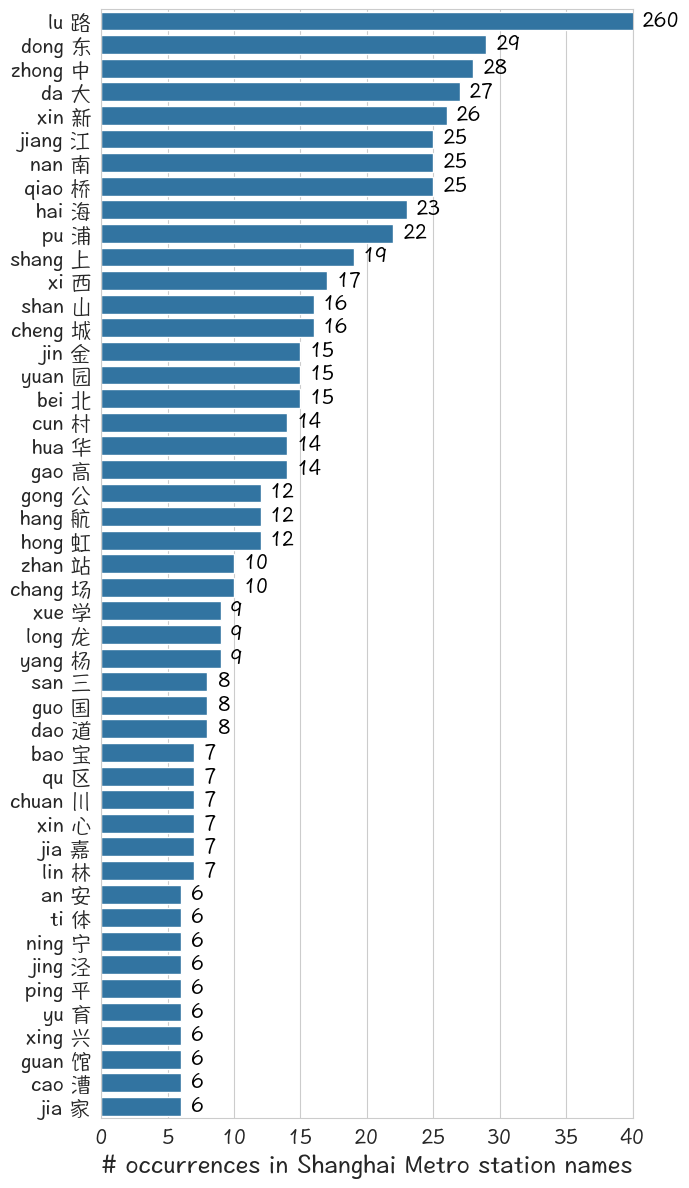

In [6]:
df_plt = char_counts[char_counts['count'] > 5]

# Plot bars
xaxis_limit = 40
plt.rcParams['font.family'] = 'Hannotate SC'
plt.figure(figsize=(7,12))
g = sns.barplot(x='count', y='char_pinyin', data=df_plt)

# Plot numbers
for index, row in df_plt.iterrows():
    g.text(x=min(row['count'], xaxis_limit) + .7,
           y=index + .2,
           s=row['count'],
           color='black',
           ha="left",
           size=15)

plt.ylabel('')
plt.xlabel('# occurrences in Shanghai Metro station names', size=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim((0,xaxis_limit))
plt.tight_layout()
    
plt.savefig('./character_rankings.png')


# 6. Character pair frequencies

In [7]:
# Get all charater sequences, not including numbers or certain characters
def replace_parentheses_and_numbers(s):
    return re.sub(r'[0-9()·号线]+', '_', s)

all_metros_str = replace_parentheses_and_numbers('_'.join(df_sh['mandarin'].values))
all_seq2 = []
for let1, let2 in zip(all_metros_str[:-1], all_metros_str[1:]):
    all_seq2.append(f'{let1}{let2}')

all_seq3 = []
for let1, let2, let3 in zip(all_metros_str[:-2], all_metros_str[1:-1], all_metros_str[2:]):
    all_seq3.append(f'{let1}{let2}{let3}')

# Remove certain characters of no interest
pair_counts = pd.Series(all_seq2).value_counts().reset_index().rename(columns={"index": 'char'})
pair_counts = pair_counts[~pair_counts['char'].str.contains('_')]
pair_counts = pair_counts[~pair_counts['char'].str.contains('站')]
pair_counts = pair_counts[~pair_counts['char'].str.contains('路')]

print(all_seq2[:5], len(all_seq2))
print(all_seq3[:5], len(all_seq3))
print(pair_counts[:5])
print(len(pair_counts), pair_counts['count'].sum())

['莘庄', '庄_', '_外', '外环', '环路'] 1881
['莘庄_', '庄_外', '_外环', '外环路', '环路_'] 1880
   char  count
2    上海     17
6    新村     12
20   大道      8
21   浦东      7
23   大学      7
585 735


In [8]:
# Get pinyin and examples
pair_counts['pinyin'] = pair_counts['char'].apply(pinyin_of_character)
pair_counts['examples'] = pair_counts['char'].apply(get_example_stations)

# Fix some of the broken pinyin
corrections = [
    ('市域', 'shichang'),
    ('育中', 'yuzhong'),
    ('浦新', 'puxin'),
]
for corrchar, corrpy in corrections:
    pair_counts.loc[pair_counts['char']==corrchar, 'pinyin'] = corrpy
pair_counts['char_pinyin'] = pair_counts.apply(lambda row: f"{row['pinyin']} {row['char']}", axis=1)

pair_counts[pair_counts['count']>3]

,char,count,pinyin,examples,char_pinyin
2,上海,17,shanghai,"[上海南站, 上海体育馆, 上海火车站, 上海马戏城, 上海科技馆]",shanghai 上海
6,新村,12,xincun,"[彭浦新村, 通河新村, 共富新村, 临沂新村, 新村路]",xincun 新村
20,大道,8,dadao,"[世纪大道, 远东大道, 浦东大道, 奉浦大道, 五洲大道]",dadao 大道
21,浦东,7,pudong,"[浦东南路(2号线), 浦东1号2号航站楼, 浦东大道, 浦东南路(14号线), 浦东足球场]",pudong 浦东
23,大学,7,daxue,"[上海大学, 松江大学城, 同济大学, 交通大学, 华东理工大学]",daxue 大学
25,公园,7,gongyuan,"[中山公园, 世纪公园, 顾村公园, 黄兴公园, 桂林公园]",gongyuan 公园
27,中心,7,zhongxin,"[国家会展中心(2号线), 源深体育中心, 上海儿童医学中心, 东方体育中心, 松江体育中心]",zhongxin 中心
39,体育,6,tiyu,"[上海体育馆, 上海体育场, 源深体育中心, 东方体育中心, 松江体育中心]",tiyu 体育
55,虹桥,5,hongqiao,"[虹桥火车站, 虹桥2号航站楼, 虹桥路, 虹桥1号航站楼, 虹桥2号航站楼(市域)]",hongqiao 虹桥
66,高桥,4,gaoqiao,"[外高桥保税区北, 外高桥保税区南, 高桥, 高桥西]",gaoqiao 高桥


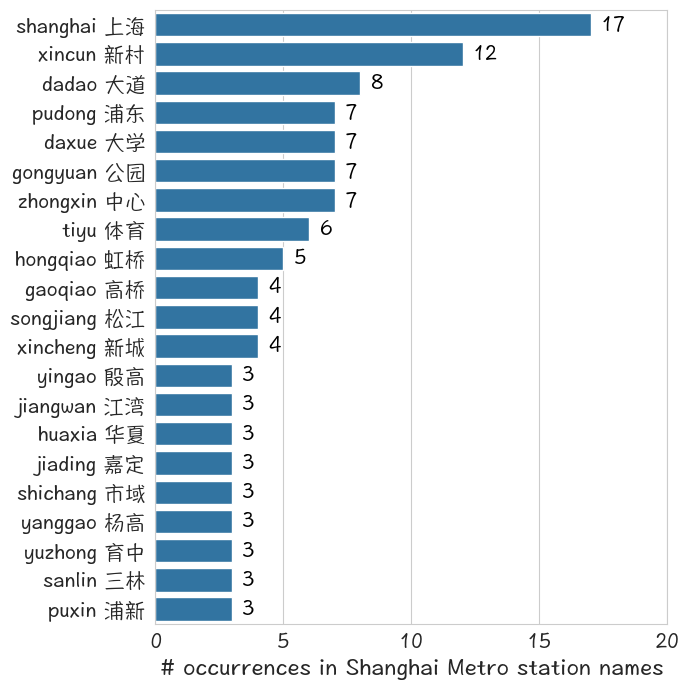

In [9]:
df_plt = pair_counts[pair_counts['count']>2].reset_index(drop=True)

# Plot bars
xaxis_limit = 20
plt.rcParams['font.family'] = 'Hannotate SC'
plt.figure(figsize=(7,7))
g = sns.barplot(x='count', y='char_pinyin', data=df_plt)

# Plot numbers
for index, row in df_plt.iterrows():
    g.text(x=min(row['count'], xaxis_limit) + .4,
           y=index + .2,
           s=row['count'],
           color='black',
           ha="left",
           size=15)

plt.ylabel('')
plt.xlabel('# occurrences in Shanghai Metro station names', size=17)
plt.xticks(np.arange(0,25,5), np.arange(0,25,5), fontsize=15)
plt.yticks(fontsize=15)
plt.xlim((0,xaxis_limit))
plt.tight_layout()
    
plt.savefig('./2combo_character_rankings.png')


# Appendix

In [ ]:
# # determine chinese-supported font

# import matplotlib.font_manager as fm
# font_list = [f for f in fm.fontManager.ttflist]
# cjk_list = ['CJK', 'Han', 'CN']
# ok_fonts = []
# for f in font_list:
#     if any(s.lower() in f.name.lower() for s in cjk_list):
#         print(f'name={f.name}, path={f.fname}')
#         ok_fonts.append(f.name)
# valid_fonts = ['HanziPen SC', 'Hannotate SC'] # 'Hiragino Sans CNS' is missing several